In [1]:
#Import packages
import os #Allows us to get operating system information in python.
#In artemis video, he did not import os package

#Data Handling
import pandas as pd, numpy as np

#Time
import time

#Plotting
import matplotlib.pyplot as plt, seaborn as sns, scipy.stats, pylab

#Saving data
import pickle

#train and test split
from sklearn.model_selection import train_test_split

#Scalers
from sklearn import preprocessing

#TomekLinks and RandomUnderSampler
from imblearn.under_sampling import TomekLinks, RandomUnderSampler


In [2]:
#Import data

f = open('CCF_EDA_Data.pckl','rb')
pickle_list = pickle.load(f)
f.close()

data = pickle_list[0]

data = data.rename(columns={"oldbalanceOrg":"oldbalanceOrig"})

Steps for Processing Data

1. Split data into train and test sets (figure out split %)
2.* Deal with missing data - DON'T HAVE TO WORRY ABOUT BECAUSE NO MISSING DATA
3. Transform numerical data so distributions are closer to a Gaussian distribution - this also includes dealing with outliers
4. TRAINING DATA ONLY - Apply TomekLink algorithm to reduce dataset
5. TRAINING DATA ONLY - Randomly undersample majority class to reduce dataset
6.* Select features - DON'T HAVE TO WORRY ABOUT BECAUSE WE HAVE VERY FEW FEATURES

# SPLIT DATA

In [3]:
#Split the dataset into training and test
train, test = train_test_split(data,test_size=0.01,random_state=5) #The value for the test size was determined from my coursera course
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [6]:
train.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,163,CASH_OUT,288726.12,C1593117495,52517.00,0.00,C1612782242,1393592.64,1682318.76,False
1,231,CASH_IN,162112.81,C1618820073,244228.00,406340.81,C348991627,0.00,0.00,False
2,253,CASH_IN,281968.13,C805318365,7039189.53,7321157.66,C1430476128,435099.86,153131.73,False
3,423,CASH_IN,328214.35,C1274111229,8959168.85,9287383.20,C337772977,7184636.59,6856422.24,False
4,397,PAYMENT,8512.96,C2026457201,0.00,0.00,M1154129826,0.00,0.00,False


In [5]:
print("Size of training data: ",str(train.shape),"\nSize of test data: ",str(test.shape))

Size of training data:  (6298993, 10) 
Size of test data:  (63627, 10)


In [4]:
train['isFraud'].value_counts() #At the beginning, there is no NA's in isFraud data

False    6290867
True        8126
Name: isFraud, dtype: Int64

In [5]:
test['isFraud'].value_counts()

False    63540
True        87
Name: isFraud, dtype: Int64

# TRANSFORM DATA 

In [4]:
#Split the data into numerical (minus step) and categorical
numerical_columns = [x for x in train.columns if train[x].dtype != 'object' and x != 'isFraud' and x != 'step']
cat_columns = [x for x in train.columns if x not in numerical_columns and x != 'isFraud']
#train_columns = [x for x in train.columns if x != 'isFraud'] #Do at the end

## Numerical Data

In [52]:
numerical_columns

['amount',
 'oldbalanceOrig',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [5]:
#Transformation methods
standard = preprocessing.StandardScaler()
normal = preprocessing.Normalizer()
robust = preprocessing.RobustScaler(quantile_range=(15,85)) #We're going with a large quantile range because the distributions are so large 

### We have too much data, so we are going to take a random sample of our training data
### to see which transformation changes the distribution closest to a Gaussian 
subtrain, other = train_test_split(train,test_size=0.99,random_state=9)

# nums = train[numerical_columns]
# l_nums = np.log(nums)
# s_nums = standard.fit_transform(nums)
# n_nums = normal.fit_transform(nums)
# r_nums = robust.fit_transform(nums)


#LEAVE ALONE, THIS TAKES TOO LONG TO RUN
#Plot numerical data with different transformations
# for col in numerical_columns:
#     tic = time.perf_counter()
#     sq_col = np.sqrt(subtrain[col])
#     s_col = standard.fit_transform(subtrain[col].to_numpy().reshape(-1,1))
#     n_col = normal.fit_transform([subtrain[col]])
#     r_col = robust.fit_transform(subtrain[col].to_numpy().reshape(-1,1))
    
#     #Set up plots
#     fig, axes = plt.subplots(2, 3, figsize=(16,8))
#     fig.suptitle(format(str(col)))
      
      #Plot
#     sns.histplot(ax=axes[0,0], data=subtrain, x=col,kde=True)
#     axes[0,0].set_title('Histogram of Regular Data')
#     sns.histplot(ax=axes[0,1], data=sq_col,kde=True)
#     axes[0,1].set_title('Histogram of Square Root Data')
#     sns.histplot(ax=axes[0,2], data=s_col,kde=True)
#     axes[0,2].set_title('Histogram of Standardized Data')
#     sns.histplot(ax=axes[1,0], data=n_col,kde=True)
#     axes[1,0].set_title('Histogram of Normalized Data')
#     sns.histplot(ax=axes[1,1], data=r_col,kde=True)
#     axes[1,1].set_title('Histogram of Robust Scaled Data')
#     toc = time.perf_counter()
#     print(f"Run Time: {toc-tic}:0.4f seconds")


In [8]:
def diagnostic_plots(df,var,trans):
    
    #transformation
    if str(trans) == "normal":
        t_var = trans.fit_transform(df[var])
    else:
        t_var = trans.fit_transform(df[var].to_numpy().reshape(-1,1))
    t_var = pd.Series(np.ndarray.tolist(t_var),name=str(var)) #Convert to a series so we can use .hist()
    t_var = t_var.apply(pd.Series).stack().reset_index(drop=True)
    
    
    plt.figure(figsize=(15,8))
    plt.suptitle(str(var))
    plt.tight_layout(h_pad=10)
    
    #Distribution of Regular Variable
    plt.subplot(2,2,1)
    df[var].hist(bins=100)
    
    #QQ-Plot of Regular Variable
    plt.subplot(2,2,2)
    scipy.stats.probplot(df[var], dist="norm", plot=pylab)
    
    #Distribution of Transformed Variable
    plt.subplot(2,2,3)
    t_var.hist(bins=100)
    
    #QQ-Plot of Transformed Variable
    plt.subplot(2,2,4)
    scipy.stats.probplot(t_var, dist="norm", plot=pylab)
    
    plt.show()

#For root transformations    
def dp_root(df,var,num):
    root_val = 1/num
    
    t_var = df[var]**root_val
    
    plt.figure(figsize=(15,8))
    plt.suptitle(str(var))
    plt.tight_layout(h_pad=10)
    
    #Distribution of Regular Variable
    plt.subplot(2,2,1)
    df[var].hist(bins=100)
    
    #QQ-Plot of Regular Variable
    plt.subplot(2,2,2)
    scipy.stats.probplot(df[var], dist="norm", plot=pylab)
    
    #Distribution of Transformed Variable
    plt.subplot(2,2,3)
    t_var.hist(bins=100)
    
    #QQ-Plot of Transformed Variable
    plt.subplot(2,2,4)
    scipy.stats.probplot(t_var, dist="norm", plot=pylab)
    
    plt.show()
    
#Didn't end up using because there are 0's in the data. If I decide to change the 0's, I'll use this function.
def dp_inverse(df,var):
    
    t_var = 1/df[var]
    
    plt.figure(figsize=(15,8))
    plt.suptitle(str(var))
    plt.tight_layout(h_pad=10)
    
    #Distribution of Regular Variable
    plt.subplot(2,2,1)
    df[var].hist(bins=100)
    
    #QQ-Plot of Regular Variable
    plt.subplot(2,2,2)
    scipy.stats.probplot(df[var], dist="norm", plot=pylab)
    
    #Distribution of Inverse Variable
    plt.subplot(2,2,3)
    t_var.hist(bins=100)
    
    #QQ-Plot of Inverse Variable
    plt.subplot(2,2,4)
    scipy.stats.probplot(t_var, dist="norm", plot=pylab)
    
    plt.show()

#Didn't end up using because there are 0's in the data. If I decide to change the 0's, I'll use this function.
def dp_log(df,var,version): #version (0 or 1): 0 = natural log, 1 = log10
    if version == 0:
        t_var = np.log(df[var])
    else:
        t_var = np.log10(df[var])

    plt.figure(figsize=(15,8))
    plt.suptitle(str(var))
    plt.tight_layout(h_pad=10)
    
    #Distribution of Regular Variable
    plt.subplot(2,2,1)
    df[var].hist(bins=100)
    
    #QQ-Plot of Regular Variable
    plt.subplot(2,2,2)
    scipy.stats.probplot(df[var], dist="norm", plot=pylab)
    
    #Distribution of Transformed Variable
    plt.subplot(2,2,3)
    t_var.hist(bins=100)
    
    #QQ-Plot of Transformed Variable
    plt.subplot(2,2,4)
    scipy.stats.probplot(t_var, dist="norm", plot=pylab)
    
    plt.show()   
    

### Standard Transformation

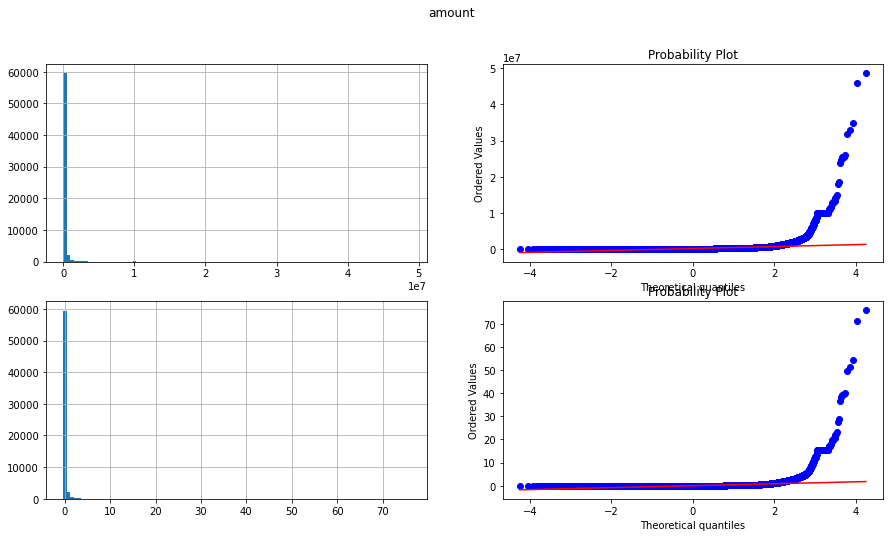

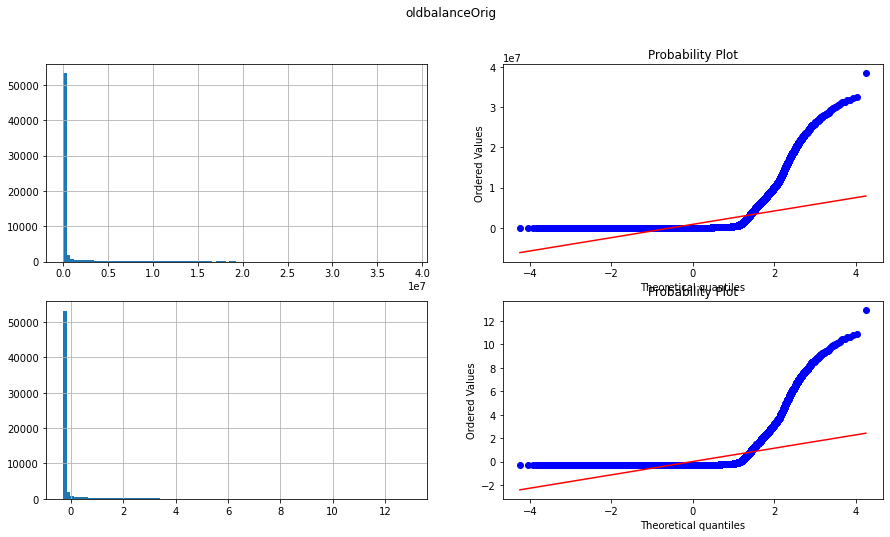

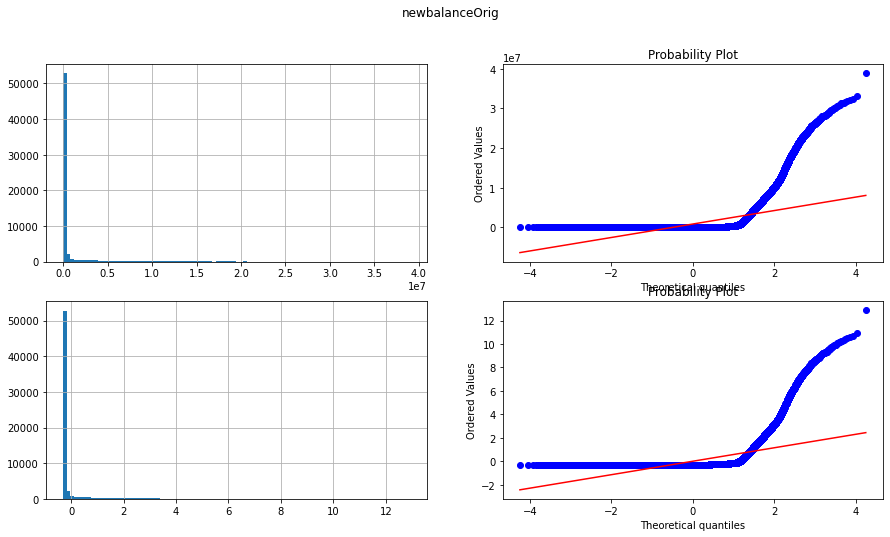

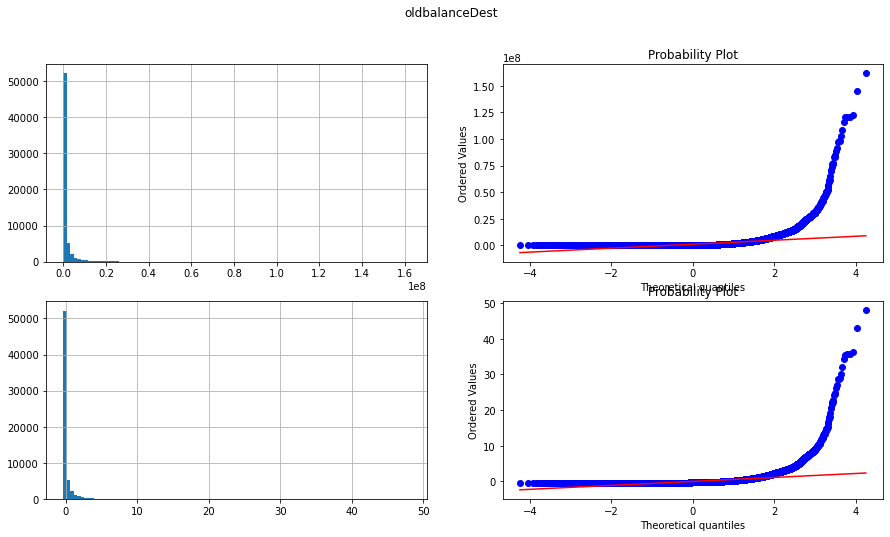

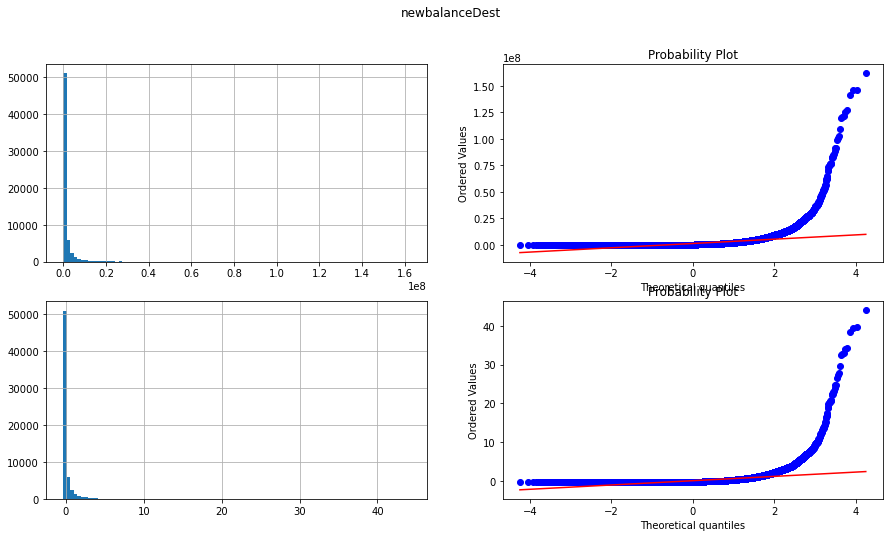

In [58]:
#amount
diagnostic_plots(subtrain,numerical_columns[0],standard)

#oldbalanceOrig
diagnostic_plots(subtrain,numerical_columns[1],standard)

#newbalanceOrig
diagnostic_plots(subtrain,numerical_columns[2],standard)

#oldbalanceDest
diagnostic_plots(subtrain,numerical_columns[3],standard)

#newbalanceDest
diagnostic_plots(subtrain,numerical_columns[4],standard)

### Normal Transformation

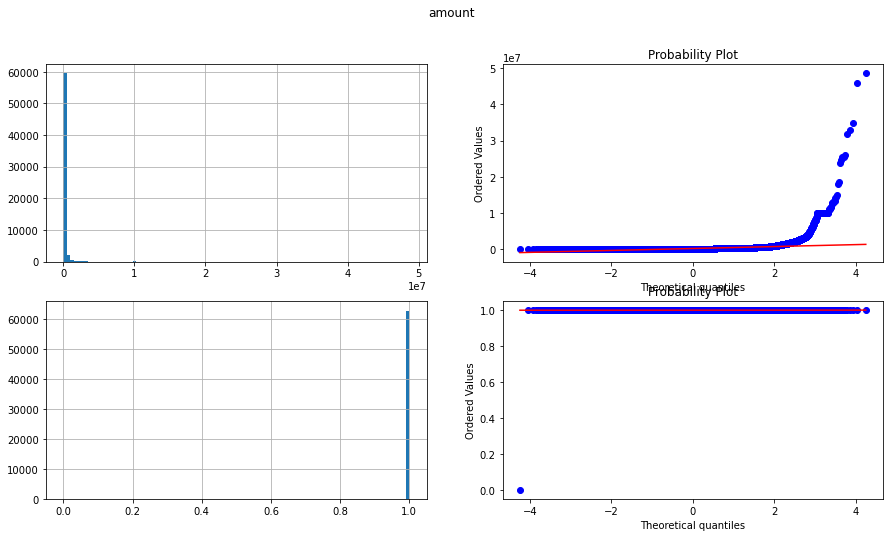

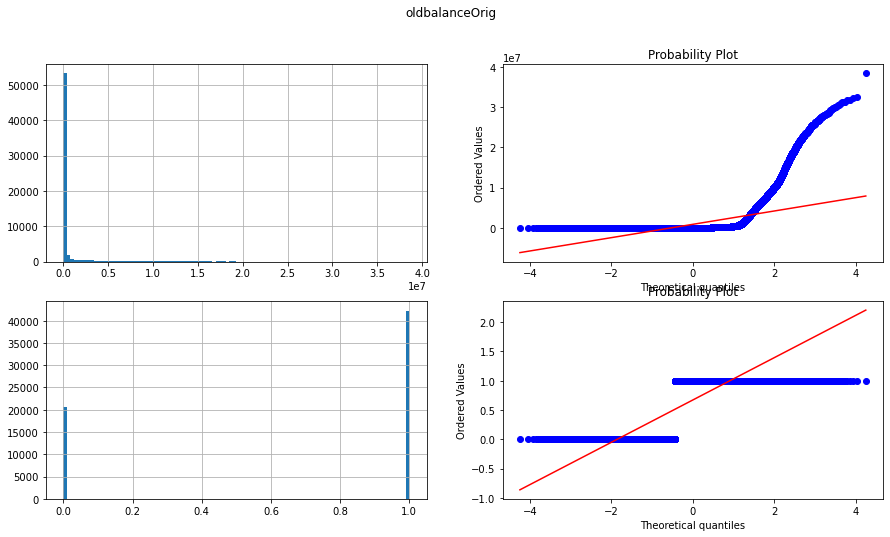

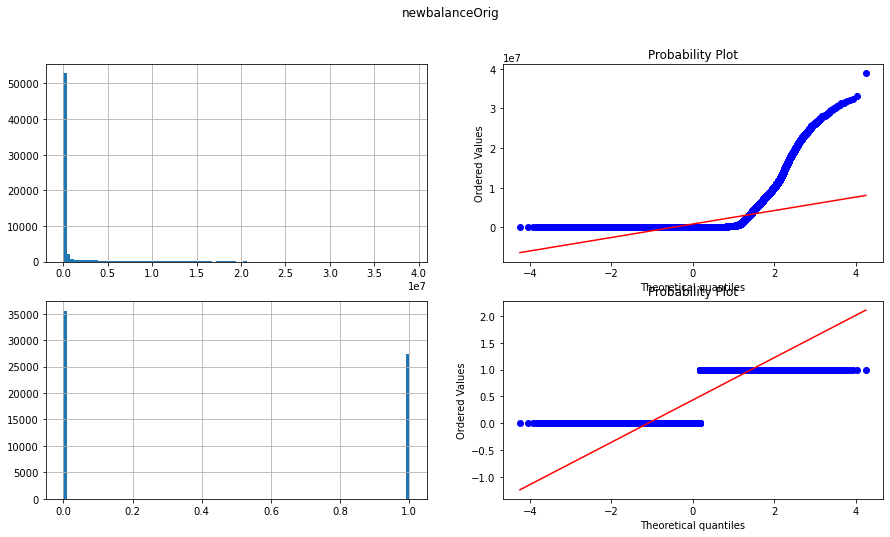

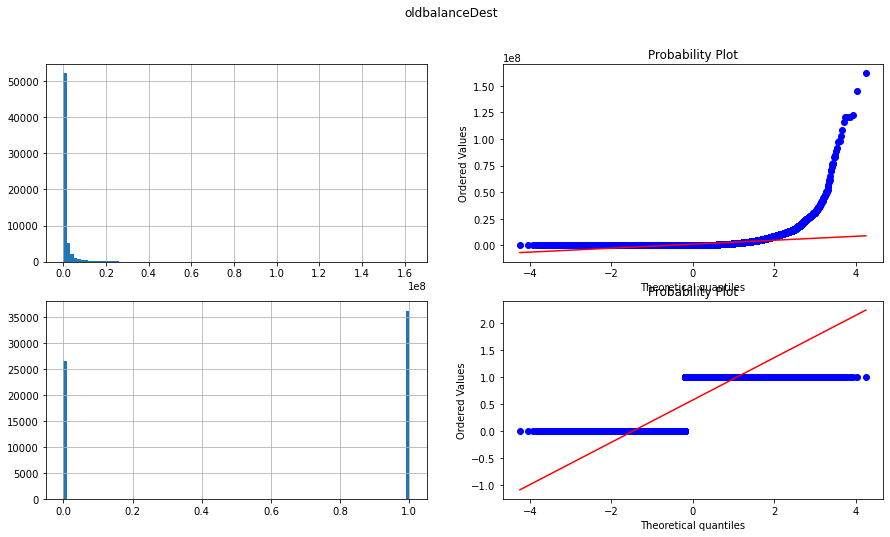

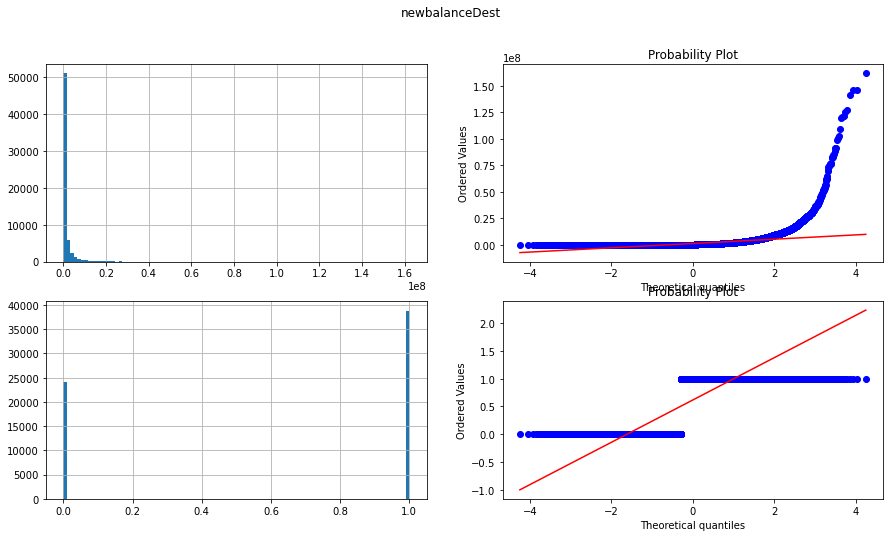

In [59]:
#amount
diagnostic_plots(subtrain,numerical_columns[0],normal)

#oldbalanceOrig
diagnostic_plots(subtrain,numerical_columns[1],normal)

#newbalanceOrig
diagnostic_plots(subtrain,numerical_columns[2],normal)

#oldbalanceDest
diagnostic_plots(subtrain,numerical_columns[3],normal)

#newbalanceDest
diagnostic_plots(subtrain,numerical_columns[4],normal)

### Robust Transformation

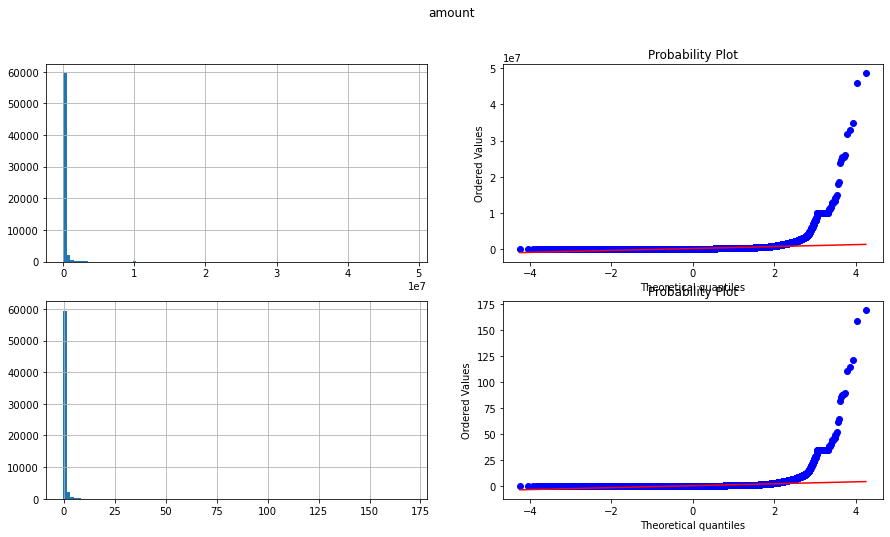

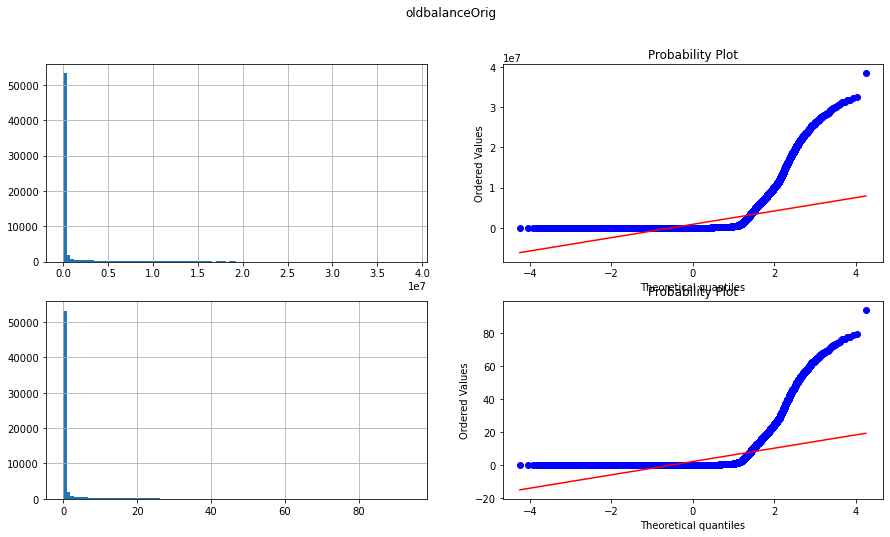

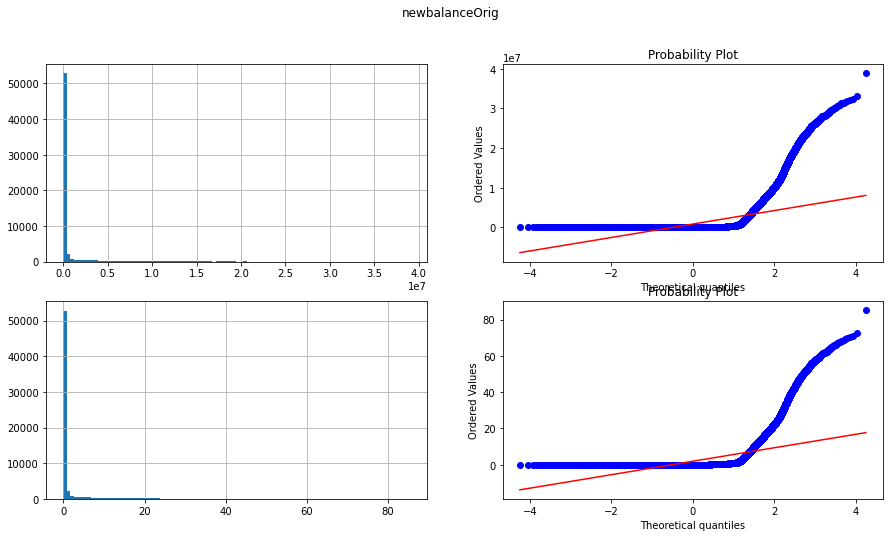

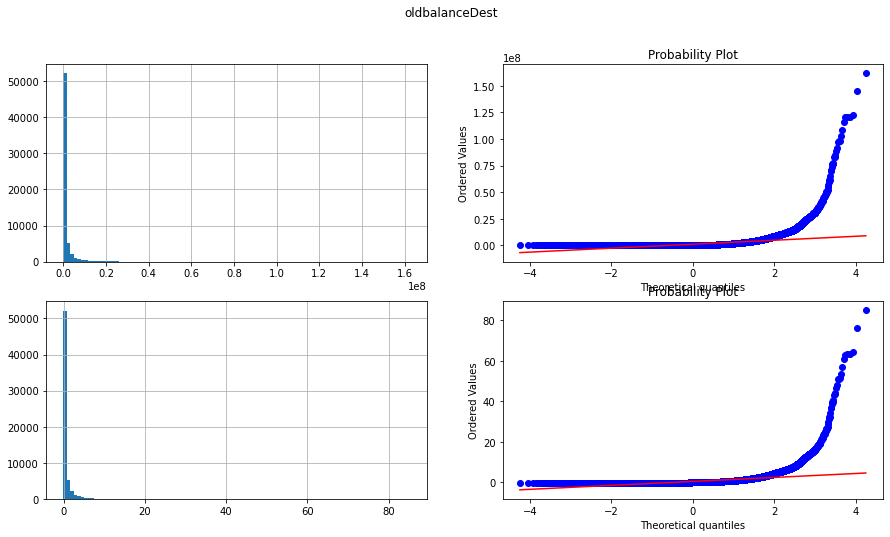

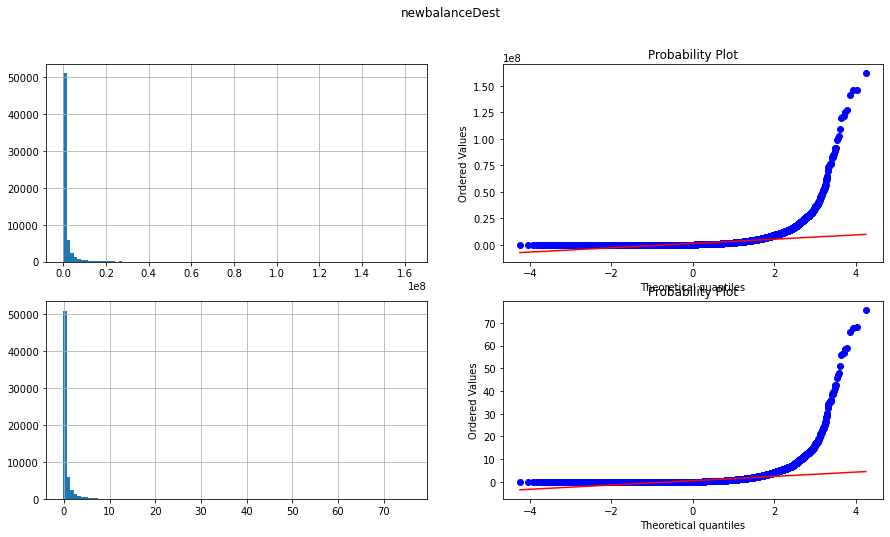

In [60]:
#amount
diagnostic_plots(subtrain,numerical_columns[0],robust)

#oldbalanceOrig
diagnostic_plots(subtrain,numerical_columns[1],robust)

#newbalanceOrig
diagnostic_plots(subtrain,numerical_columns[2],robust)

#oldbalanceDest
diagnostic_plots(subtrain,numerical_columns[3],robust)

#newbalanceDest
diagnostic_plots(subtrain,numerical_columns[4],robust)

### Square Root Transformation

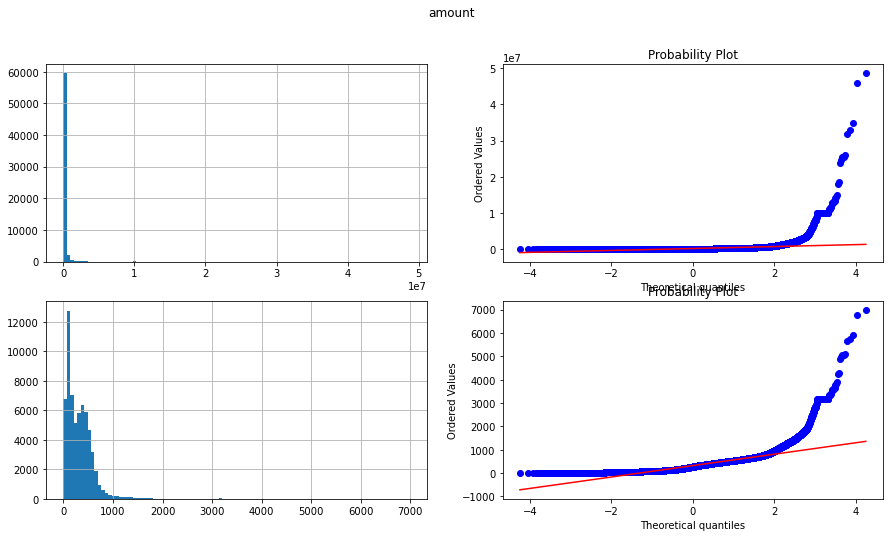

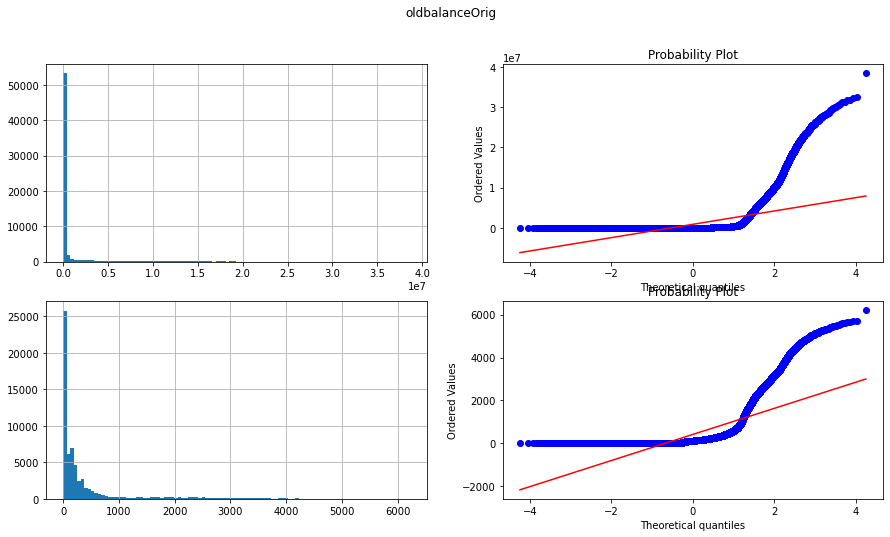

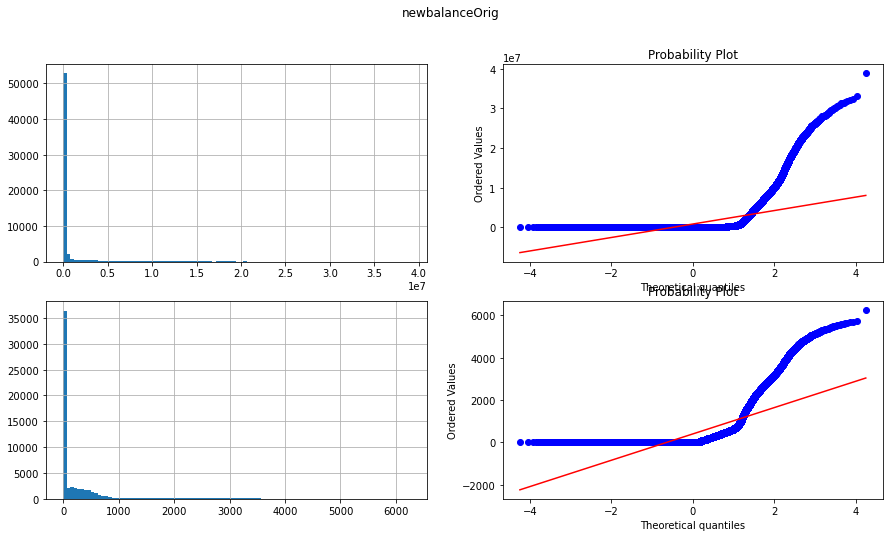

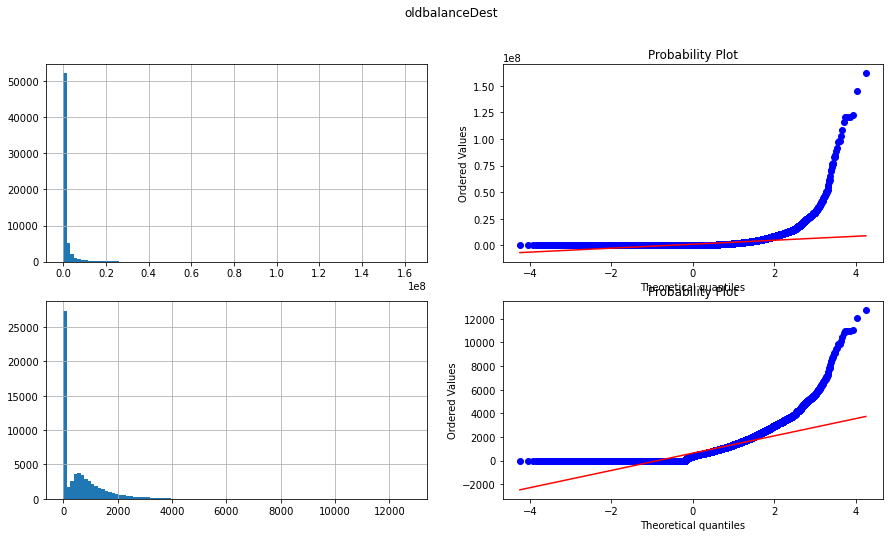

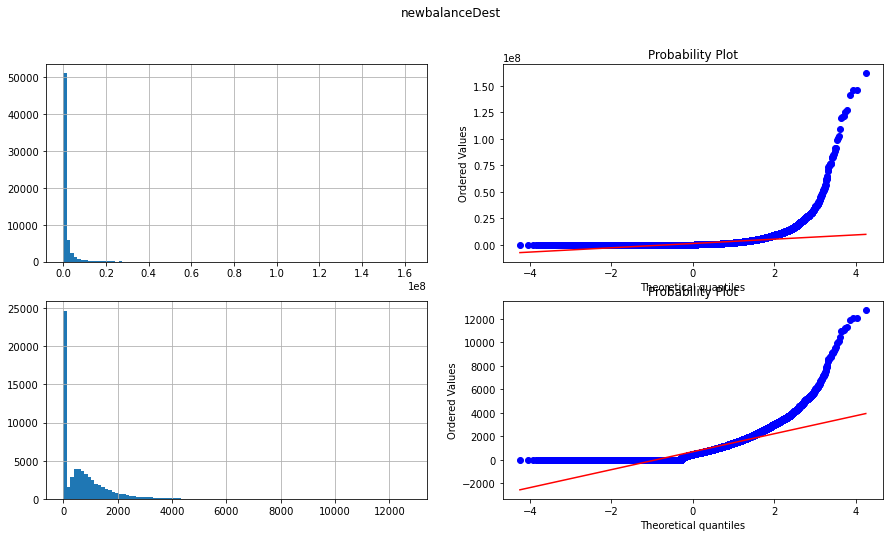

In [63]:
#amount
dp_root(subtrain,numerical_columns[0],2)

#oldbalanceOrig
dp_root(subtrain,numerical_columns[1],2)

#newbalanceOrig
dp_root(subtrain,numerical_columns[2],2)

#oldbalanceDest
dp_root(subtrain,numerical_columns[3],2)

#newbalanceDest
dp_root(subtrain,numerical_columns[4],2)

### 4 Root Transformation 

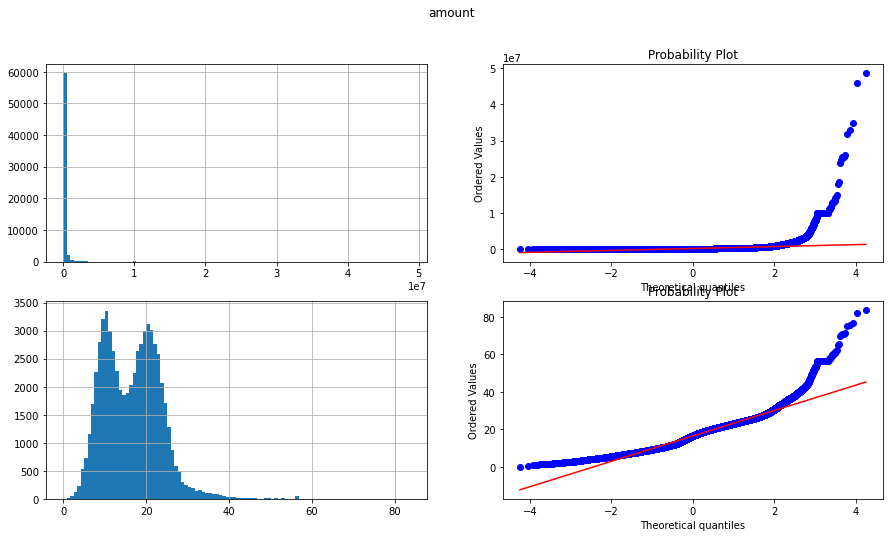

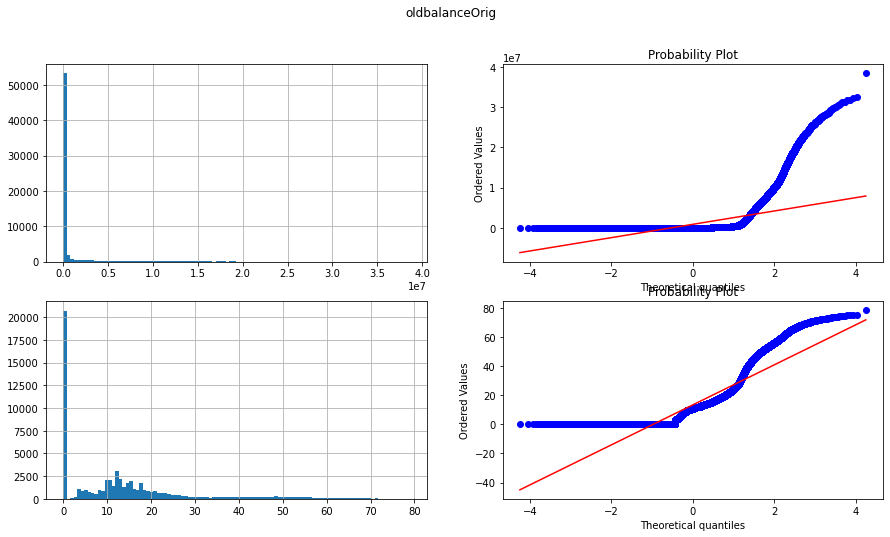

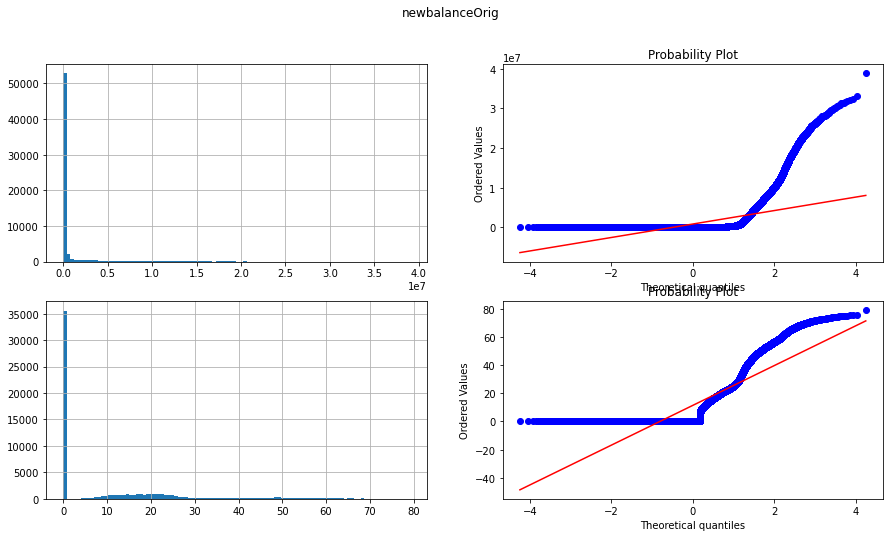

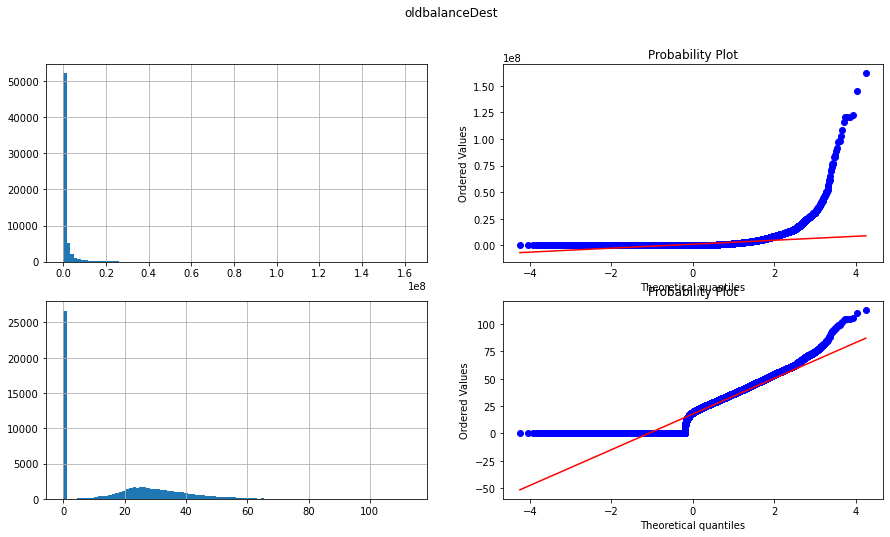

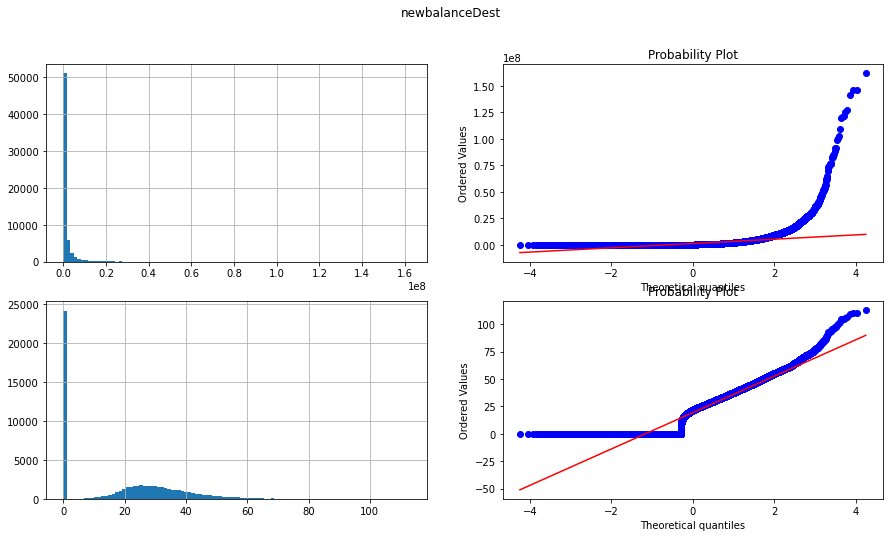

In [64]:
#amount
dp_root(subtrain,numerical_columns[0],4)

#oldbalanceOrig
dp_root(subtrain,numerical_columns[1],4)

#newbalanceOrig
dp_root(subtrain,numerical_columns[2],4)

#oldbalanceDest
dp_root(subtrain,numerical_columns[3],4)

#newbalanceDest
dp_root(subtrain,numerical_columns[4],4)

### 6 Root Transformation

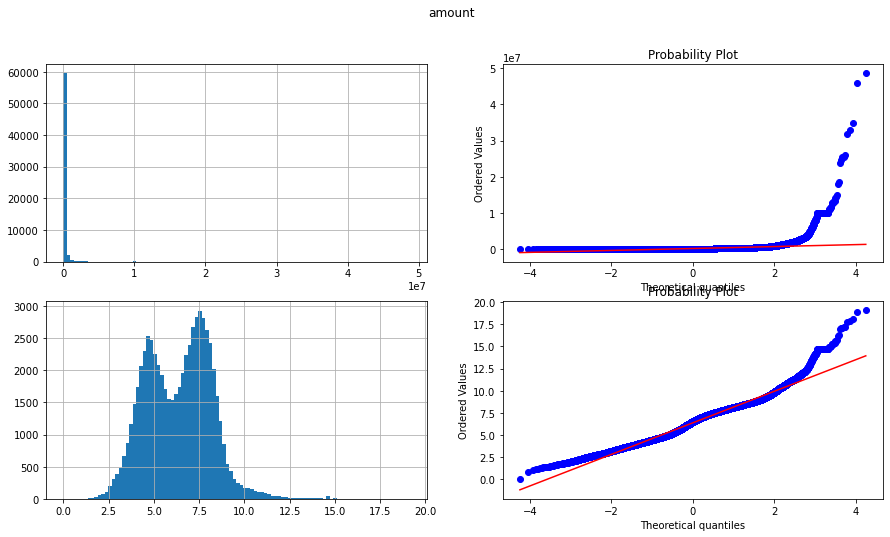

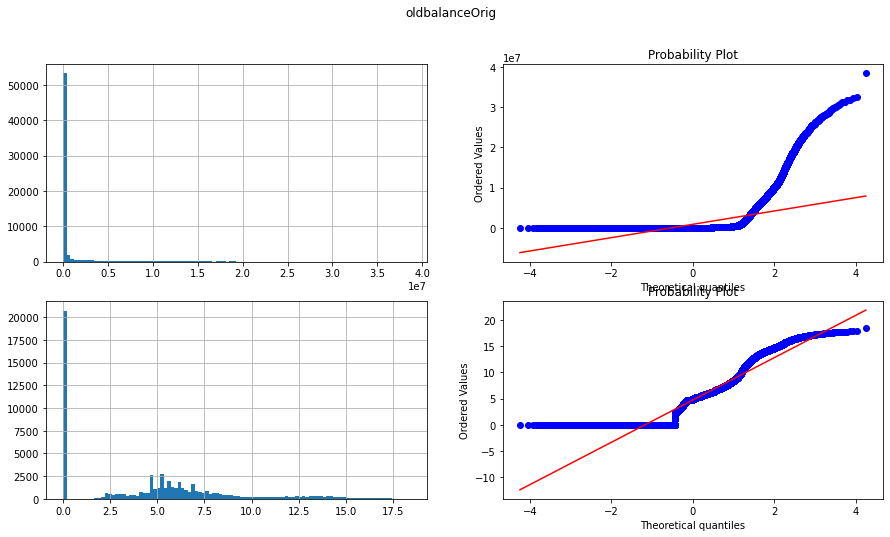

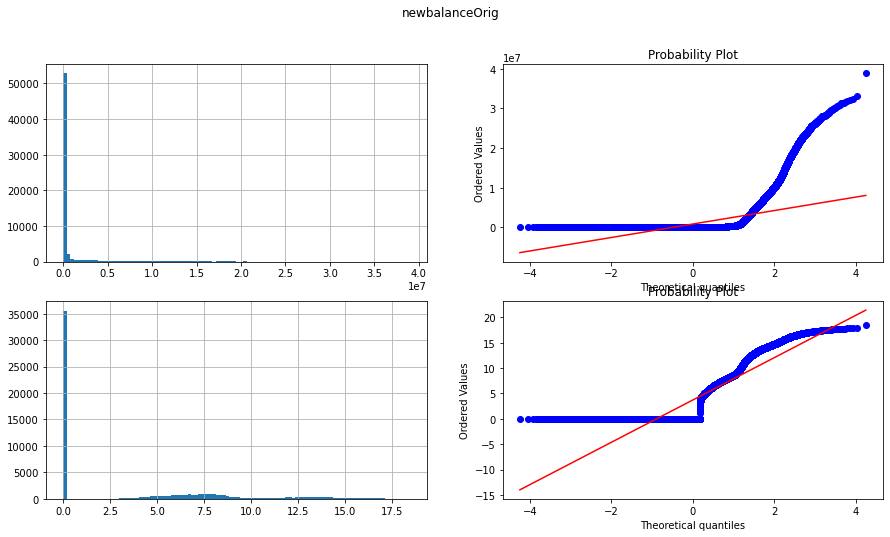

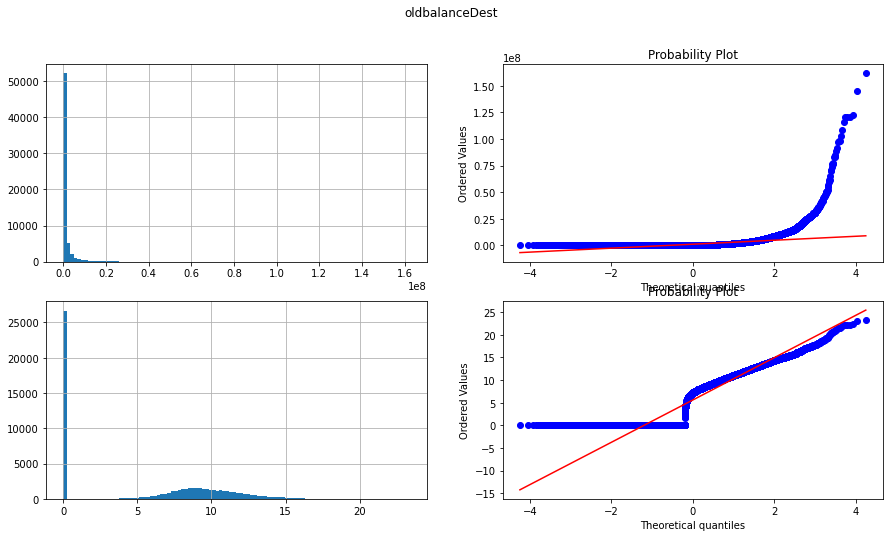

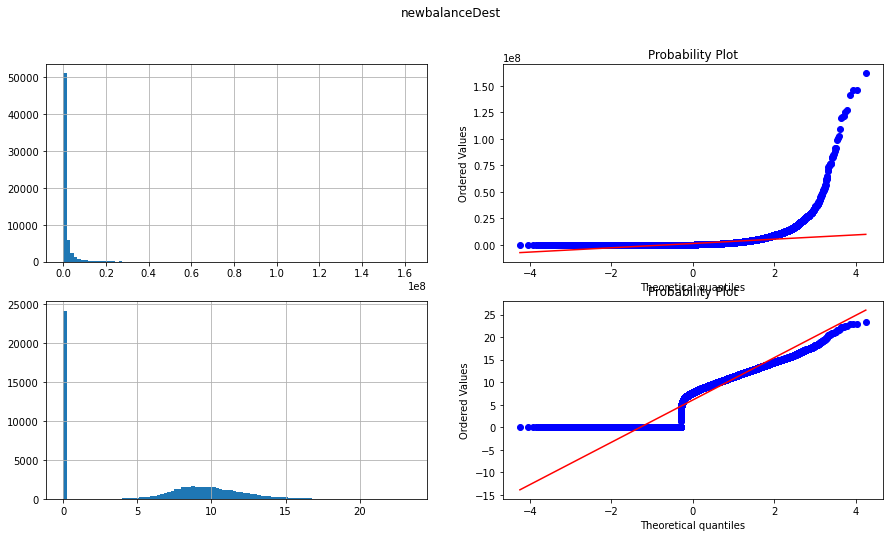

In [9]:
#amount
dp_root(subtrain,numerical_columns[0],6)

#oldbalanceOrig
dp_root(subtrain,numerical_columns[1],6)

#newbalanceOrig
dp_root(subtrain,numerical_columns[2],6)

#oldbalanceDest
dp_root(subtrain,numerical_columns[3],6)

#newbalanceDest
dp_root(subtrain,numerical_columns[4],6)

#### TEST CODE 

In [19]:
#TEST 1
# w= [1,2,3,4]
# print(len(w))
# print(w)
# print(type(w))

# x = standard.fit_transform(subtrain[numerical_columns[1]].to_numpy().reshape(-1,1))
# print("=========================")
# print(len(x))
# print(x)
# print(type(x))

# y = pd.Series(np.ndarray.tolist(x))
# print("=========================")
# print(y.shape)
# print(y)
# print(type(y))

# z = subtrain[numerical_columns[1]]
# print("=========================")
# print(z.shape)
# print(z)
# print(type(z))

#TEST 2
#x = standard.fit_transform(subtrain[numerical_columns[1]].to_numpy().reshape(-1,1))
#y = pd.Series(np.ndarray.tolist(x))
# print(y)
# print(type(y))
#z = y.apply(pd.Series).stack().reset_index(drop=True)
#s = s.apply(pd.Series).stack().reset_index(drop = True)
# print(z)
# print(type(z))

### Transforming the Data

In [5]:
#4 Root Transformation is the winner!

#amount
train['amount_4root'] = train['amount']**(1/4)
#oldbalanceOrig
train['oldbalanceOrig_4root'] = train['oldbalanceOrig']**(1/4)
#newbalanceOrig
train['newbalanceOrig_4root'] = train['newbalanceOrig']**(1/4)
#oldbalanceDest
train['oldbalanceDest_4root'] = train['oldbalanceDest']**(1/4)
#newbalanceDest
train['newbalanceDest_4root'] = train['newbalanceDest']**(1/4)

#Make sure the columns are added to dataframe
#train.head()

#Drop old columns
train2 = train.drop(numerical_columns,axis=1)
new_cols = train2.columns.tolist()
new_cols = new_cols[-5:] + new_cols[:-5]
train = train2[new_cols]
train.head() #move added columns to the front

,amount_4root,oldbalanceOrig_4root,newbalanceOrig_4root,oldbalanceDest_4root,newbalanceDest_4root,step,type,nameOrig,nameDest,isFraud
0,23.180432,15.138226,0.000000,34.358481,36.014474,163,CASH_OUT,C1593117495,C1612782242,False
1,20.065701,22.230481,25.247746,0.000000,0.000000,231,CASH_IN,C1618820073,C348991627,False
2,23.043583,51.508709,52.016957,25.683088,19.781822,253,CASH_IN,C805318365,C1430476128,False
3,23.935328,54.710027,55.204355,51.772746,51.171057,423,CASH_IN,C1274111229,C337772977,False
4,9.605504,0.000000,0.000000,0.000000,0.000000,397,PAYMENT,C2026457201,M1154129826,False


### Categorical Data

In [22]:
cat_columns

['step', 'type', 'nameOrig', 'nameDest']

In [6]:
#Type is straightforward to one-hot encode. But the name variables will be difficult.

####### Proof of concept

# #nameOrig
# dum_train = train
# dummy = dum_train.loc[:,'nameOrig'].tolist() #Grab a column
# dummy2 = [i[0] for i in dummy] #Grab first character for each string 
# dummy3 = [i[1:] for i in dummy] #Grab ID# after first character
# dummy4 = [1 if i=='C' else 0 for i in dummy2] #Give True values if i == 'C'
# dum_train['ClientOrig'] = dummy4 #Create new variable for letter in df
# dum_train['ClientOrig'] = dum_train['ClientOrig'].astype('boolean') #Convert to boolean
# dum_train['CO_ID'] = dummy3 #Create new variable for ID#
# dum_train = dum_train.drop('nameOrig',axis=1) #Drop the old variable
# cols = dum_train.columns.tolist() #grab current columns from dataframe
# cols = cols[-2:] + cols[:-2] #rearrange columns so these are brought to the front
# dum_train = dum_train[cols]
# print(dum_train.head(5))

# #nameDest
# dum_train2 = train
# dummy5 = dum_train2['nameDest'].tolist() 
# dummy6 = [i[0] for i in dummy5]
# dummy7 = [i[1:] for i in dummy5]
# dummy8 = [1 if i=='C' else 0 for i in dummy6]
# dum_train2['ClientDest'] = dummy8
# dum_train2['ClientDest'] = dum_train2['ClientDest'].astype('boolean')
# dum_train2['CD_ID'] = dummy7
# dum_train2 = dum_train2.drop('nameDest',axis=1)
# cols = dum_train2.columns.tolist()
# cols = cols[-2:] + cols[:-2]
# dum_train2 = dum_train2[cols]
# print(dum_train2.head(5))
# print(dum_train2.dtypes)

In [6]:
#nameOrig and nameDest (front letter conversion)
nOt = train['nameOrig'].tolist() #convert the series to a list
nDt = train['nameDest'].tolist()

#Grab first letter
nOt_first = [i[0] for i in nOt]
nDt_first = [i[0] for i in nDt]

#Grab ID #
nOt_ID = [i[1:] for i in nOt]
nDt_ID = [i[1:] for i in nDt]

#Create new arrays that give 1 if first letter = 'C' and 0 if first letter = 'M'
nOt_bool = [1 if i=='C' else 0 for i in nOt_first]
nDt_bool = [1 if i=='C' else 0 for i in nDt_first]

#Create new columns for boolean variable
train['ClientOrig'] = nOt_bool
train['ClientOrig'] = train['ClientOrig'].astype('bool')
train['ClientDest'] = nDt_bool
train['ClientDest'] = train['ClientDest'].astype('bool')

#Create new columns for ID #'s
#We create new columns in the data because this allows us to use .value_counts() later
train['NO_ID'] = nOt_ID
train['ND_ID'] = nDt_ID

#Drop old columns
train = train.drop(['nameOrig','nameDest'],axis=1)

#Move the columns
new_cols = train.columns.tolist()
new_cols = new_cols[-4:] + new_cols[:-4]
train = train[new_cols]

print(train.head(10))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

   ClientOrig  ClientDest       NO_ID       ND_ID  amount_4root  \
0        True        True  1593117495  1612782242     23.180432   
1        True        True  1618820073   348991627     20.065701   
2        True        True   805318365  1430476128     23.043583   
3        True        True  1274111229   337772977     23.935328   
4        True       False  2026457201  1154129826      9.605504   
5        True        True  1098189121   422085411     12.746229   
6        True        True  1714367763  1481734474     19.646700   
7        True        True   482079441  1338255129     20.623273   
8        True       False  1015184994   822590544     10.428227   
9        True        True   752828953   591128489     14.273761   

   oldbalanceOrig_4root  newbalanceOrig_4root  oldbalanceDest_4root  \
0             15.138226              0.000000             34.358481   
1             22.230481             25.247746              0.000000   
2             51.508709             52.016957    

In [7]:
#nameOrig and nameDest (ID #)
#I will go with my Repeat and No Repeat idea for each column

#Create pivot tables for each column and grab the IDs
nameOrig_tab = train['NO_ID'].value_counts()
nameOrig_tabIDs = nameOrig_tab.index
nameDest_tab = train['ND_ID'].value_counts()
nameDest_tabIDs = nameDest_tab.index

#print(len(train)-len(nameOrig_tab)) #9123 is the difference in sizes 

#Find all names that repeat for each column
repeat_nOtab = nameOrig_tab[nameOrig_tab>1]
repeat_nOtIDs = repeat_nOtab.index #Important info

###### Explaination #######
#repeat_nOtab and nameOrig_tab have different sizes because there are 9093 names that appear 
#two times and 15 names that appear 3 times. Therefore train should have 
#9093 + 2*(15) = 9123 more rows than nameOrig_tab.
#When we remove all names that appear only once, we get 9093 + 15 = 9108 rows for repeat_nOtab

repeat_nDtab = nameDest_tab[nameDest_tab>1]
repeat_nDtIDs = repeat_nDtab.index #Important info

#Find the IDs that repeat in train[NO_ID] and assign them 0. All other values, assign 1
#nameOrig
no_bool = []
for no_id in train['NO_ID']:
    if no_id in repeat_nOtIDs:
        no_bool.append(0)
    else:
        no_bool.append(1)

#nameDest
nd_bool = []
for nd_id in train['ND_ID']:
    if nd_id in repeat_nDtIDs:
        nd_bool.append(0)
    else:
        nd_bool.append(1)


#Add the new columns to our dataset
train['NO_ID_unique'] = no_bool
train['NO_ID_unique'] = train['NO_ID_unique'].astype('bool')
train['ND_ID_unique'] = nd_bool
train['ND_ID_unique'] = train['ND_ID_unique'].astype('bool')

#Drop the old ID columns
train = train.drop(['NO_ID','ND_ID'],axis=1)

#Move the columns
new_cols = train.columns.tolist()
new_cols = new_cols[-2:] + new_cols[:-2]
train = train[new_cols]

train.head(10)

,NO_ID_unique,ND_ID_unique,ClientOrig,ClientDest,amount_4root,oldbalanceOrig_4root,newbalanceOrig_4root,oldbalanceDest_4root,newbalanceDest_4root,step,type,isFraud
0,True,False,True,True,23.180432,15.138226,0.000000,34.358481,36.014474,163,CASH_OUT,False
1,True,False,True,True,20.065701,22.230481,25.247746,0.000000,0.000000,231,CASH_IN,False
2,True,False,True,True,23.043583,51.508709,52.016957,25.683088,19.781822,253,CASH_IN,False
3,True,False,True,True,23.935328,54.710027,55.204355,51.772746,51.171057,423,CASH_IN,False
4,True,True,True,False,9.605504,0.000000,0.000000,0.000000,0.000000,397,PAYMENT,False
5,True,False,True,True,12.746229,16.863310,15.277162,29.550306,29.802781,257,CASH_OUT,False
6,True,False,True,True,19.646700,4.959511,19.666614,29.144707,27.507204,356,CASH_IN,False
7,True,False,True,True,20.623273,10.036549,20.906586,0.000000,0.000000,303,CASH_IN,False
8,True,True,True,False,10.428227,14.588082,13.525112,0.000000,0.000000,372,PAYMENT,False
9,True,False,True,True,14.273761,10.171773,15.116422,17.829986,15.621789,19,CASH_IN,False


In [59]:
#Testing
# len(no_bool) == len(train)
# len(no_bool) - sum(no_bool) #This value makes sense because it is 9093*2 + 15*3 = 18231

# len(repeat_nDtab)
# len(nameDest_tab)

In [5]:
#One-Hot Encode 'type' Variable
ohe = preprocessing.OneHotEncoder(handle_unknown="ignore",drop='first',sparse=False)

#encoded_data = pd.DataFrame(data=ohe.fit_transform(train[cat_columns]), columns=ohe.get_feature_names_out())
type_encoded = pd.DataFrame(data=ohe.fit_transform(train['type'].array.reshape(-1,1)), columns=ohe.get_feature_names_out())

#Grab the column names from the encoded data
e_col = type_encoded.columns.tolist()

#Convert each column into a boolean
for col in e_col:
    type_encoded[col] = type_encoded[col].astype('bool')

#Add columns to dataframe
train = pd.concat([type_encoded,train],axis=1) #I believe this may be the origin of the NA isFraud problem

#Drop type column
train = train.drop('type',axis=1)

train.head(10)

,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER,step,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,True,False,False,False,163,288726.12,C1593117495,52517.00,0.00,C1612782242,1393592.64,1682318.76,False
1,False,False,False,False,231,162112.81,C1618820073,244228.00,406340.81,C348991627,0.00,0.00,False
2,False,False,False,False,253,281968.13,C805318365,7039189.53,7321157.66,C1430476128,435099.86,153131.73,False
3,False,False,False,False,423,328214.35,C1274111229,8959168.85,9287383.20,C337772977,7184636.59,6856422.24,False
4,False,False,True,False,397,8512.96,C2026457201,0.00,0.00,M1154129826,0.00,0.00,False
5,True,False,False,False,257,26395.32,C1098189121,80867.00,54471.68,C422085411,762514.16,788909.49,False
6,False,False,False,False,356,148990.45,C1714367763,605.00,149595.45,C1481734474,721504.05,572513.60,False
7,False,False,False,False,303,180896.58,C482079441,10147.00,191043.58,C1338255129,0.00,0.00,False
8,False,False,True,False,372,11826.11,C1015184994,45289.00,33462.89,M822590544,0.00,0.00,False
9,False,False,False,False,19,41510.09,C752828953,10705.00,52215.09,C591128489,101065.76,59555.67,False


In [6]:
#6/17/23
#I need to save the OneHotEncoder so I can use it for the testing data
ohe_list = [ohe] #The OneHotEncoder
f = open('OHE.pckl','wb')
pickle.dump(ohe_list,f)
f.close()

In [12]:
#Now when we look at the data, the total # of value counts does not match the rows
print(train['isFraud'].value_counts())
print(train['isFraud'].shape)
#train[train['isFraud'].isna()] #All rows with an NA

False    6290867
True        8126
Name: isFraud, dtype: Int64
(6298993,)


### Time Data 

In [9]:
#There are a couple of things we can do with the time variable, 
#but we will not do them for this project. See OneNotes for some ideas.
#We will drop the time variable (step)
train = train.drop('step',axis=1)
train.head(10)

,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER,NO_ID_unique,ND_ID_unique,ClientOrig,ClientDest,amount_4root,oldbalanceOrig_4root,newbalanceOrig_4root,oldbalanceDest_4root,newbalanceDest_4root,isFraud
0,True,False,False,False,True,False,True,True,23.180432,15.138226,0.000000,34.358481,36.014474,False
1,False,False,False,False,True,False,True,True,20.065701,22.230481,25.247746,0.000000,0.000000,False
2,False,False,False,False,True,False,True,True,23.043583,51.508709,52.016957,25.683088,19.781822,False
3,False,False,False,False,True,False,True,True,23.935328,54.710027,55.204355,51.772746,51.171057,False
4,False,False,True,False,True,True,True,False,9.605504,0.000000,0.000000,0.000000,0.000000,False
5,True,False,False,False,True,False,True,True,12.746229,16.863310,15.277162,29.550306,29.802781,False
6,False,False,False,False,True,False,True,True,19.646700,4.959511,19.666614,29.144707,27.507204,False
7,False,False,False,False,True,False,True,True,20.623273,10.036549,20.906586,0.000000,0.000000,False
8,False,False,True,False,True,True,True,False,10.428227,14.588082,13.525112,0.000000,0.000000,False
9,False,False,False,False,True,False,True,True,14.273761,10.171773,15.116422,17.829986,15.621789,False


## TOMEK LINKS

In [10]:
#Apply TomekLinks algorithm to majority class in training data
tlink = TomekLinks(sampling_strategy='majority', n_jobs=2)

#Create modeling data dataframe by removing isFraud column
modeling_data_columns = [x for x in train.columns if x!= 'isFraud']
modeling_data = train[modeling_data_columns]
modeling_data.head(10)

,x0_CASH_OUT,x0_DEBIT,x0_PAYMENT,x0_TRANSFER,NO_ID_unique,ND_ID_unique,ClientOrig,ClientDest,amount_4root,oldbalanceOrig_4root,newbalanceOrig_4root,oldbalanceDest_4root,newbalanceDest_4root
0,True,False,False,False,True,False,True,True,23.180432,15.138226,0.000000,34.358481,36.014474
1,False,False,False,False,True,False,True,True,20.065701,22.230481,25.247746,0.000000,0.000000
2,False,False,False,False,True,False,True,True,23.043583,51.508709,52.016957,25.683088,19.781822
3,False,False,False,False,True,False,True,True,23.935328,54.710027,55.204355,51.772746,51.171057
4,False,False,True,False,True,True,True,False,9.605504,0.000000,0.000000,0.000000,0.000000
5,True,False,False,False,True,False,True,True,12.746229,16.863310,15.277162,29.550306,29.802781
6,False,False,False,False,True,False,True,True,19.646700,4.959511,19.666614,29.144707,27.507204
7,False,False,False,False,True,False,True,True,20.623273,10.036549,20.906586,0.000000,0.000000
8,False,False,True,False,True,True,True,False,10.428227,14.588082,13.525112,0.000000,0.000000
9,False,False,False,False,True,False,True,True,14.273761,10.171773,15.116422,17.829986,15.621789


In [11]:
#Convert the 'isFraud' target variable into an 'int' dtype
train['isFraud'] = train['isFraud'].astype('int')

#Resample the data
X, y = tlink.fit_resample(modeling_data, train['isFraud'])
tomek_modeling_data = pd.DataFrame(data=X, columns=modeling_data_columns)

In [12]:
print(tomek_modeling_data.shape) #Removed 715 rows (6,298,993 - 6,298,278 = 715)
y = pd.DataFrame(y,columns=['isFraud']) #Change to dataframe

(6298278, 13)


## RANDOM UNDER-SAMPLING

In [13]:
rus = RandomUnderSampler(sampling_strategy='majority',random_state=2)

X2, y2 = rus.fit_resample(tomek_modeling_data, y)
rus_tomek_modeling_data = pd.DataFrame(data=X2,columns=tomek_modeling_data.columns)

In [14]:
print(rus_tomek_modeling_data.shape)
y2 = pd.DataFrame(y2,columns=['isFraud'])

(16252, 13)


# SAVE DATA

In [15]:
pickle_list = [tomek_modeling_data, y, rus_tomek_modeling_data, y2, test] #Two training datasets, plus the test data
f = open('CCF_ProcessedData.pckl','wb')
pickle.dump(pickle_list,f)
f.close()